In [1]:
# !git clone https://github.com/derronqi/yolov7-face yolo7_face

In [2]:
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt

from yolo7_face.models.experimental import attempt_load
from yolo7_face.utils.general import check_img_size, non_max_suppression, scale_coords
from yolo7_face.utils.datasets import letterbox
from yolo7_face.utils.plots import plot_one_box

In [3]:
def preprocess_yolo_face_input(image: np.ndarray, img_size: int, stride: int):
    prep_img = letterbox(image, img_size, stride=stride, auto=False)[0]
    
    # Convert BGR to RGB, to shape 3 x img_size x img_size
    prep_img = prep_img[:, :, ::-1].transpose(2, 0, 1)
    prep_img = np.ascontiguousarray(prep_img)

    prep_img = torch.from_numpy(prep_img).to('cpu')
    prep_img = prep_img.float() / 255
    prep_img = prep_img.unsqueeze(0)

    return prep_img

def detect_faces(image: np.ndarray,
                 weights: str = '../models/yolov7-lite-s.pt',
                 img_size: int = 640,
                 conf_threshold: float = 0.25,
                 iou_threshold: float = 0.45):

    model = attempt_load(weights, map_location='cpu')
    stride = int(model.stride.max())
    img_size = check_img_size(img_size, s=stride)

    prep_img = preprocess_yolo_face_input(image, img_size, stride)

    prediction = model(prep_img, augment=False)[0]
    prediction = non_max_suppression(prediction, conf_threshold, iou_threshold, kpt_label=5)

    detection = prediction[0]
    scale_coords(prep_img.shape[2:], detection[:, :4], image.shape, kpt_label=False)

    detection = np.array(detection)
    bounding_boxes = detection[:, :4].astype(int)
    confidences = detection[:, 4]
    return bounding_boxes, confidences

In [4]:
def plot_bounding_boxes(image: np.ndarray,
                        bounding_boxes: np.ndarray,
                        confidences: np.ndarray):

    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    for xyxy, conf in zip(bounding_boxes, confidences):
        label = f'face {conf:.2f}'
        color = (0, 0, 255)
        plot_one_box(xyxy, image, color, label, steps=3, orig_shape=image.shape[:2])

    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [6]:
%matplotlib inline

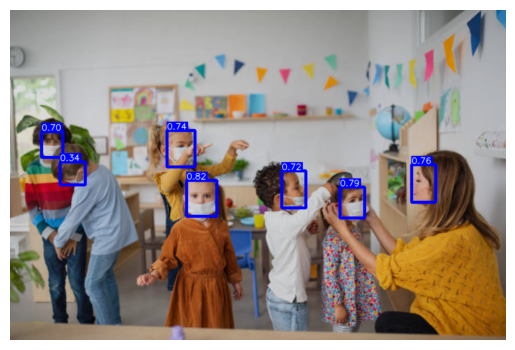

In [7]:
image = cv2.imread('5.png')
bounding_boxes, confidences = detect_faces(image)
plot_bounding_boxes(image, bounding_boxes, confidences)

In [2]:
!pip install ptflops

  Preparing metadata (setup.py) ... done
  Created wheel for ptflops: filename=ptflops-0.7.1.2-py3-none-any.whl size=13231 sha256=c46a5880d6d58efaa9f4baab1926611ca36026416fa5a0c699a06763b810393f
  Stored in directory: /root/.cache/pip/wheels/2a/3b/52/58673eece6c499444e3d9eabb3625ac231b7de6170459ce302
Successfully built ptflops


In [5]:
from ptflops import get_model_complexity_info


model = attempt_load('../models/yolov7-lite-s.pt', map_location='cpu')

macs, params = get_model_complexity_info(model, (3, 640, 640), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)

Model(
  0, 0.000% Params, 1.46 GMac, 98.515% MACs, 
  (model): Sequential(
    0, 0.000% Params, 1.46 GMac, 98.515% MACs, 
    (0): StemBlock(
      0, 0.000% Params, 327.68 MMac, 22.159% MACs, 
      (stem_1): Conv(
        0, 0.000% Params, 95.03 MMac, 6.426% MACs, 
        (conv): Conv2d(0, 0.000% Params, 88.47 MMac, 5.983% MACs, 3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(0, 0.000% Params, 6.55 MMac, 0.443% MACs, 32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(0, 0.000% Params, 0.0 Mac, 0.000% MACs, inplace=True)
      )
      (stem_2a): Conv(
        0, 0.000% Params, 55.71 MMac, 3.767% MACs, 
        (conv): Conv2d(0, 0.000% Params, 52.43 MMac, 3.546% MACs, 32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(0, 0.000% Params, 3.28 MMac, 0.222% MACs, 16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(0, 0.000% Params, 0.0 

In [7]:
import re

# Extract the numerical value
flops = eval(re.findall(r'([\d.]+)', macs)[0])*2

# Extract the unit
flops_unit = re.findall(r'([A-Za-z]+)', macs)[0][0]
print('Computational complexity: {:<8}'.format(macs))
print('Computational complexity: {} {}Flops'.format(flops, flops_unit))
print('Number of parameters: {:<8}'.format(params))

Computational complexity: 1.48 GMac
Computational complexity: 2.96 GFlops
Number of parameters: 0       
